# Lending Behaviour Analysis
### Ethan Burke

### Load Libraries

In [127]:
import pandas as pd
import numpy as np
import sqlalchemy as sq
import matplotlib.pyplot as plt
import requests
import csv
import io as StringIO
import seaborn as sns

### Connect to MySQL

In [128]:
username = 'ethan_burke'
password = 'vuurjyFwOACqu'
host = 'datasciencedb.ucalgary.ca'
database = 'ethan_burke'
port = '3306'  


conn_url = f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}"
engine = sq.create_engine(conn_url)

In [14]:


url = 'https://www.bankofcanada.ca/valet/observations/STATIC_ATABLE_V39079/json'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    #print(data)
else:
    print("Error:", response.status_code)
    
observations = data['observations']

olr_df = pd.DataFrame(observations)


olr_df = pd.json_normalize(data['observations'], sep='_')


olr_df['Rate'] = olr_df['STATIC_ATABLE_V39079_v'].astype(float)
olr_df.drop('STATIC_ATABLE_V39079_v', axis=1, inplace=True)

# Rename 'd' to 'Date'
olr_df.rename(columns={'d': 'Date'}, inplace=True)


olr_df.head()

,Date,Rate
0,1996-01-01,5.56
1,1996-02-01,5.19
2,1996-03-01,5.00
3,1996-04-01,4.75
4,1996-05-01,4.75


### Put 'ir' table into database

In [ ]:
conn = engine.connect()
olr_df.to_sql('ir', con=engine, if_exists='append', index=False)
conn.close()

### Loan to Income Ratio Explanation


Loan to income ratio:

The Loan to income (LTI) ratio  is a metric that evaluates the affordability of a mortgage upon purchase. A higher LTI indicates higher vulnerability to financial stress.  This stress could be caused by a loss of income, unexpected expense or a rise in mortgage interest rates.  Having a high LTI ratio increases the probability of falling behind on dept payments and thus is a factor in evaluating the reality of the lending conditions.  

### Loan to Income Ratio Query

In [129]:
# Connect to the database
conn = engine.connect()
query = """
SELECT 
  lti.date,
  slos.SLOS_ML_LEND_NP AS Non_Price_Lending_Condition_Score,
  slos.SLOS_ML_LEND_PC AS Price_Lending_Condition_Score,
  lti.FVI_MEDIAN_LTI_FTHB AS LTI_FirstTime,
  lti.FVI_MEDIAN_LTI_REPEAT AS LTI_RepeatBuyers,
  lti.FVI_MEDIAN_LTI_INVESTORS AS LTI_Investors
FROM 
  ethan_burke.fvi_loan_to_income_ratio AS lti
JOIN 
  ethan_burke.slos AS slos
ON 
  lti.date = slos.date;
"""
lc_lti = pd.read_sql(query, con=engine)
conn.close()

lc_lti = lc_lti.iloc[:24]
lc_lti.head()



,date,Non_Price_Lending_Condition_Score,Price_Lending_Condition_Score,LTI_FirstTime,LTI_RepeatBuyers,LTI_Investors
0,2017Q1,34.54,11.32,355.03,317.09,218.74
1,2017Q2,8.59,-11.34,345.36,307.16,223.32
2,2017Q3,16.33,20.82,350.89,311.02,232.58
3,2017Q4,9.46,9.36,351.58,314.74,224.10
4,2018Q1,54.73,14.52,343.48,312.82,225.73


### Loan to Income Ratio Home Buyers Plot

/var/folders/np/czhdb9qs1nv51rr1q76l8_br0000gn/T/ipykernel_99198/3840924071.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lc_lti['date'] = pd.to_datetime(lc_lti['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


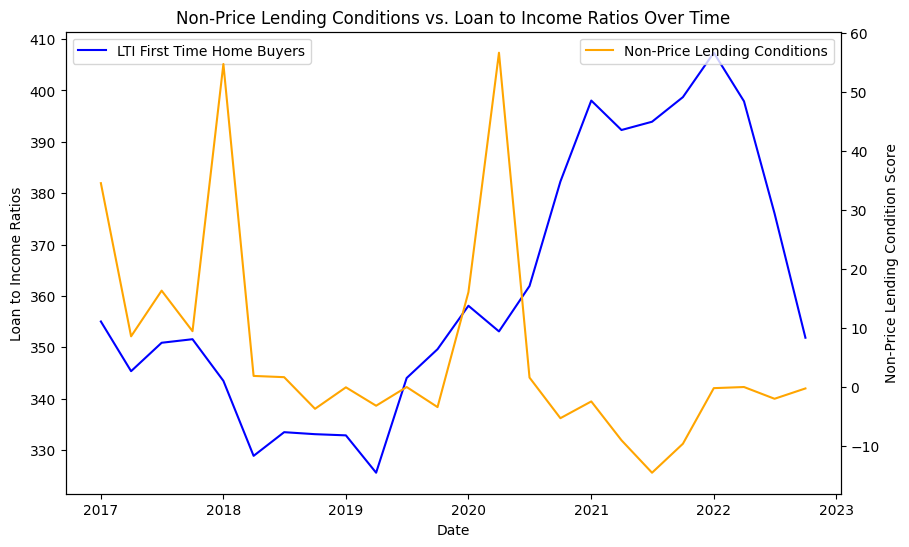

In [130]:
lc_lti['date'] = pd.to_datetime(lc_lti['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


plt.figure(figsize=(10, 6))


ax1 = plt.gca()  # Gets the current axis
ax1.plot(lc_lti['date'], lc_lti['LTI_FirstTime'], label='LTI First Time Home Buyers', color='blue')


# Create the second axis
ax2 = ax1.twinx()  # creates a second y-axis sharing x-axis
ax2.plot(lc_lti['date'], lc_lti['Non_Price_Lending_Condition_Score'], label='Non-Price Lending Conditions', color='orange')

# title, labels, and legends
plt.title('Non-Price Lending Conditions vs. Loan to Income Ratios Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Loan to Income Ratios')
ax2.set_ylabel('Non-Price Lending Condition Score')

# legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


plt.show()

### Loan to Income Result

This query facilitates filtering and pairing data by date from the Loan to Income Ratio dataset and the Senior Loan Officer Survey. It maintains distinct categories for different types of home buyers—first-time buyers, repeat buyers, and investors (involved in activities such as rental properties or property flipping). This approach enables a comparative analysis to discern how banks differentially treat these various buyer segments. 

As we can see, all three categories of buyers LTI ratio followed a similar trend with the repeat homebuyers and the first time home buyers showing very high correlation. The loan to income ratio shows that loans given to first time homebuyers have the gretest multiple over their income.  The discrepancy between first time, repeat and investor LTI is presumed to be as a result of increased income with age, however, this may be an inaccurate assumption.  Perhaps the descrepancy is as a result of self selection as investors aren't as willing to leverage themselves as heavily for an investment, as a first time homebuyer is.   

All three categories appear to have poor correlation with the lending condition score suggesting that the loan officers sentiment has less to do with the degree to which individuals leverage themselves than the interest rate of their mortgage.  As the trigger rate was reached in Q3 2022, we see the LTI ratio fall as presumably people are buying cheaper houses as to be able to afford the high-interest on the mortgage.  This effect is less dramatic in the investor category as the trigger rate shows a stagnation in the LTI for a quarter before also dropping at a similar rate.


In [155]:


url = 'https://www.bankofcanada.ca/valet/observations/FVI_MTG_LTVAVE_FTHB,FVI_MTG_LTVAVE_REPEAT,FVI_MTG_LTVAVE_INVESTORS/json'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    #print(data)
else:
    print("Error:", response.status_code)
    
observations = data['observations']


ota_df = pd.DataFrame(observations)


ota_df = pd.json_normalize(data['observations'], sep='_')

# Extracting values from nested dictionary
ota_df['LTV_FTHB'] = ota_df['FVI_MTG_LTVAVE_FTHB_v'].astype(float)
ota_df['LTV_REPEAT'] = ota_df['FVI_MTG_LTVAVE_REPEAT_v'].astype(float)
ota_df['LTV_INVESTORS'] = ota_df['FVI_MTG_LTVAVE_INVESTORS_v'].astype(float)
ota_df.drop('FVI_MTG_LTVAVE_FTHB_v', axis=1, inplace=True)
ota_df.drop('FVI_MTG_LTVAVE_REPEAT_v', axis=1, inplace=True)
ota_df.drop('FVI_MTG_LTVAVE_INVESTORS_v', axis=1, inplace=True)

# Rename 'd' to 'Date'
ota_df.rename(columns={'d': 'Date'}, inplace=True)
ota_df['Date'] = pd.to_datetime(ota_df['Date'])
ota_df['Date'] = ota_df['Date'].dt.to_period('Q')
ota_df['Date'] = ota_df['Date'].dt.strftime('%YQ%q')

ota_df.head()

,Date,LTV_FTHB,LTV_REPEAT,LTV_INVESTORS
0,2014Q1,79.15,76.79,76.89
1,2014Q2,81.07,77.89,77.49
2,2014Q3,80.33,76.88,76.89
3,2014Q4,80.16,77.05,76.67
4,2015Q1,79.99,76.97,75.92


In [156]:
conn = engine.connect()
ota_df.to_sql('ltv', con=engine, if_exists='append', index=False)
conn.close()

In [5]:
conn = engine.connect()
query = """
SELECT 
  ltv.Date,
  slos.SLOS_ML_LEND AS Lending_Condition_Score,
  slos.SLOS_ML_LEND_PC AS Mortgage_Price_Lending_Conditions,
  slos.SLOS_ML_LEND_NP AS Mortgage_NonPrice_Lending_Conditions,
  ltv.LTV_FTHB AS LTV_FirstTime,
  ltv.LTV_REPEAT AS LTV_Repeat,
  ltv.LTV_INVESTORS AS LTV_Investors
FROM 
  ethan_burke.ltv AS ltv
JOIN 
  ethan_burke.slos AS slos
ON 
  ltv.Date = slos.date;
"""
lc_ltv = pd.read_sql(query, con=engine)
conn.close()

df = lc_ltv
df.head()

,Date,Lending_Condition_Score,Mortgage_Price_Lending_Conditions,Mortgage_NonPrice_Lending_Conditions,LTV_FirstTime,LTV_Repeat,LTV_Investors
0,2017Q1,22.93,11.32,34.54,78.58,74.49,75.13
1,2017Q2,-1.37,-11.34,8.59,79.50,74.99,75.25
2,2017Q3,18.58,20.82,16.33,79.28,74.51,75.09
3,2017Q4,9.41,9.36,9.46,79.26,74.40,75.18
4,2018Q1,34.63,14.52,54.73,79.03,74.00,75.17


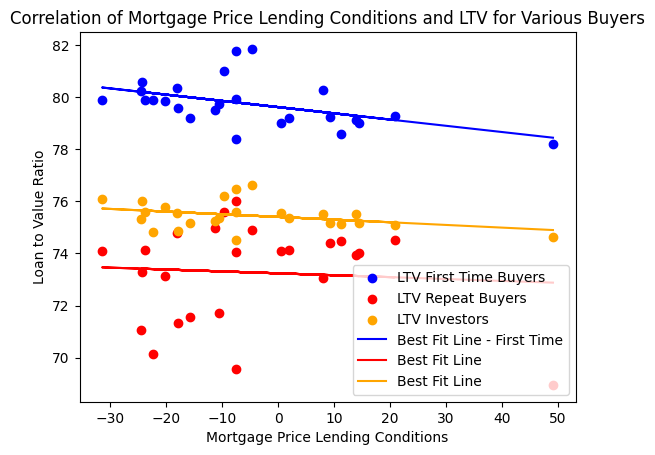

In [124]:

ax1 = plt.gca()

# scatter plot
ax1.scatter(df['Mortgage_Price_Lending_Conditions'], df['LTV_FirstTime'], color='blue', label='LTV First Time Buyers')
ax1.scatter(df['Mortgage_Price_Lending_Conditions'], df['LTV_Repeat'], color='red', label='LTV Repeat Buyers')
ax1.scatter(df['Mortgage_Price_Lending_Conditions'], df['LTV_Investors'], color='orange', label='LTV Investors')
# Calculate best-fit line
slope_ft, intercept_ft = np.polyfit(df['Mortgage_Price_Lending_Conditions'], df['LTV_FirstTime'], 1)
best_fit_line_ft = slope_ft * df['Mortgage_Price_Lending_Conditions'] + intercept_ft

slope_rpt, intercept_rpt = np.polyfit(df['Mortgage_Price_Lending_Conditions'], df['LTV_Repeat'], 1)
best_fit_line_rpt = slope_rpt * df['Mortgage_Price_Lending_Conditions'] + intercept_rpt

slope_inv, intercept_inv = np.polyfit(df['Mortgage_Price_Lending_Conditions'], df['LTV_Investors'], 1)
best_fit_line_inv = slope_inv * df['Mortgage_Price_Lending_Conditions'] + intercept_inv
# Plot best-fit line
ax1.plot(df['Mortgage_Price_Lending_Conditions'], best_fit_line_ft, color='blue', label='Best Fit Line - First Time')
ax1.plot(df['Mortgage_Price_Lending_Conditions'], best_fit_line_rpt, color='red', label='Best Fit Line')
ax1.plot(df['Mortgage_Price_Lending_Conditions'], best_fit_line_inv, color='orange', label='Best Fit Line')
# Adding labels
plt.xlabel('Mortgage Price Lending Conditions')
plt.ylabel('Loan to Value Ratio')
plt.title('Correlation of Mortgage Price Lending Conditions and LTV for Various Buyers')
plt.legend()

plt.show()

### Price vs Non-Price Conditions

Looking at the price vs non price conditions, it appears that the price conditions seem to move in big jumps where as the non price will make smaller hops and then large jumps.  This may be due to their direct link with factors like monetary policy and economic indicators.  As these factors change, the price conditions react swiftly in response.  Non-price conditions will tend to fluctuate less until they make a vary large leap, often in response to a major economic shift or regulatory change.  

In [ ]:
import plotly.graph_objs as go

# Sample data: Replace these with your actual data
categories = df['LTV_FirstTime', 'LTI', 'Interest Rate', 'Mortgage_Price_Lending_Conditions', '% Variable Rate', 'Amortization Period']

# Data for each group
first_time_buyers = [70, 5, 3.5, 50, 50, 25]
repeat_buyers = [60, 4, 3.0, 60, 40, 20]
investors = [80, 6, 4.0, 40, 60, 30]

# Create traces for each group
trace1 = go.Scatterpolar(
    r=first_time_buyers,
    theta=categories,
    fill='toself',
    name='First Time Buyers'
)

trace2 = go.Scatterpolar(
    r=repeat_buyers,
    theta=categories,
    fill='toself',
    name='Repeat Buyers'
)

trace3 = go.Scatterpolar(
    r=investors,
    theta=categories,
    fill='toself',
    name='Investors'
)

data = [trace1, trace2, trace3]

# Layout settings
layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]  # Adjust the range based on your data
        )
    ),
    showlegend=True
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


In [74]:

SA_df = pd.read_csv('bank_comments_chatty.txt', sep='|', header=None, names=['bank','extracted_comment','sentiment','date'])
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0, 'Mixed': 0, 'Non-specific': 0}
SA_df['Sentiment_Score'] = SA_df['sentiment'].map(sentiment_map)

SA_df['date'] = pd.to_datetime(SA_df['date'].str.strip(), errors='coerce')
SA_df.set_index('date', inplace=True)
quarterly_counts = SA_df.resample('Q')['Sentiment_Score'].mean()*100
SA_df.head()

SA_df['extracted_comment'] = SA_df['extracted_comment'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii') if isinstance(x, str) else x)

# Assuming your date index is already in datetime format
quarterly_counts.index = quarterly_counts.index.to_period('Q')

# If you want to convert this to a string in the format 'YYYYQ#'
quarterly_counts.index = quarterly_counts.index.strftime('%YQ%q')
quarterly_counts = quarterly_counts.reset_index()
quarterly_counts.head()


,date,Sentiment_Score
0,2015Q3,-53.846154
1,2015Q4,NaN
2,2016Q1,0.000000
3,2016Q2,NaN
4,2016Q3,NaN


In [118]:

SA_df2 = pd.read_csv('bank_of_comments.csv')


SA_df2['created_at'] = pd.to_datetime(SA_df2['created_at'])
SA_df2.set_index('created_at', inplace=True)
quarterly_counts2 = SA_df2.resample('Q')['roberta_polarity'].mean()*100
SA_df2.head()



# Assuming your date index is already in datetime format
quarterly_counts2.index = quarterly_counts2.index.to_period('Q')

# If you want to convert this to a string in the format 'YYYYQ#'
quarterly_counts2.index = quarterly_counts2.index.strftime('%YQ%q')
quarterly_counts2 = quarterly_counts2.reset_index()
quarterly_counts2.head()


,created_at,roberta_polarity
0,2015Q3,-11.222621
1,2015Q4,NaN
2,2016Q1,-17.622448
3,2016Q2,NaN
4,2016Q3,NaN


In [100]:
conn = engine.connect()
quarterly_counts2.to_sql('SA_luke_Q2', con=engine, if_exists='append', index=False)
conn.close()

/var/folders/np/czhdb9qs1nv51rr1q76l8_br0000gn/T/ipykernel_49361/107155018.py:2: UserWarning: The provided table name 'SA_luke_Q2' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  quarterly_counts2.to_sql('SA_luke_Q2', con=engine, if_exists='append', index=False)


In [127]:
conn = engine.connect()
query = """
SELECT 
  slos.date AS Quarter,
  SA_luke_Q2.roberta_polarity,
  slos.SLOS_ML_LEND AS Lending_Condition_Score,
  slos.SLOS_ML_LEND_PC AS Mortgage_Price_Lending_Conditions,
  slos.SLOS_ML_LEND_NP AS Mortgage_NonPrice_Lending_Conditions
FROM 
  ethan_burke.slos AS slos
INNER JOIN 
  ethan_burke.SA_luke_Q2 AS SA_luke_Q2
ON 
  slos.date = SA_luke_Q2.created_at
GROUP BY 
  slos.date, 
  SA_luke_Q2.roberta_polarity,
  slos.SLOS_ML_LEND, 
  slos.SLOS_ML_LEND_PC, 
  slos.SLOS_ML_LEND_NP
ORDER BY 
  slos.date;


  """
SA_Luke = pd.read_sql(query, con=engine)
conn.close()

df = SA_Luke
df.head()

,Quarter,roberta_polarity,Lending_Condition_Score,Mortgage_Price_Lending_Conditions,Mortgage_NonPrice_Lending_Conditions
0,2017Q1,-23.285745,22.93,11.32,34.54
1,2017Q2,NaN,-1.37,-11.34,8.59
2,2017Q3,-8.865104,18.58,20.82,16.33
3,2017Q4,-4.862892,9.41,9.36,9.46
4,2018Q1,-17.191958,34.63,14.52,54.73


/var/folders/np/czhdb9qs1nv51rr1q76l8_br0000gn/T/ipykernel_49361/2126384124.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Quarter'] = pd.to_datetime(df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


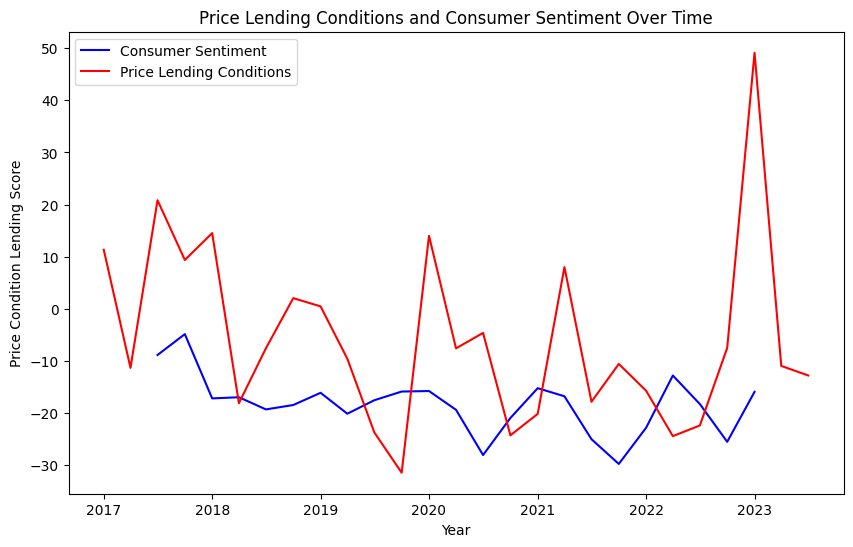

0.2706260520469214


In [128]:
df['Quarter'] = pd.to_datetime(df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()  # Gets the current axis
ax1.plot(df['Quarter'], df['roberta_polarity'], label='Consumer Sentiment', color='blue')
ax1.plot(df['Quarter'], df['Mortgage_Price_Lending_Conditions'], label='Price Lending Conditions', color='red')

plt.title('Price Lending Conditions and Consumer Sentiment Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Consumer Sentiment')
ax1.set_ylabel('Price Condition Lending Score')

# legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

correlation = df['roberta_polarity'].corr(df['Mortgage_Price_Lending_Conditions'])
print(correlation)


The observed correlation coefficient of 0.27 between consumer sentiment and price conditions indicates a modestly positive relationship. However, it is imperative to note that the data on consumer sentiment is uniformly negative. This trend may be attributed to the nature of discussions on platforms like Reddit, where discourse often gravitates towards critical, negative and sarcastic views, particularly in the context of banking services. Alternatively, this pattern could reflect a prevailing negative sentiment among consumers towards the banking sector. Considering the correlation between price conditions and consumer sentiment, it can be inferred that factors such as fees and interest rates are pivotal in influencing consumer attitudes. This observation further validates the significance of costs in shaping consumer perceptions of banking institutions.

### All Variable Query

In [118]:
conn = engine.connect()
query = """
SELECT 
  slos.date AS Quarter,
  AVG(ir.Rate) AS Avg_Rate,
  slos.SLOS_ML_LEND AS Lending_Condition_Score,
  slos.SLOS_ML_LEND_PC AS Mortgage_Price_Lending_Conditions,
  slos.SLOS_ML_LEND_NP AS Mortgage_NonPrice_Lending_Conditions,
  lti.FVI_MEDIAN_LTI_FTHB AS LTI_FirstTime,
  lti.FVI_MEDIAN_LTI_REPEAT AS LTI_RepeatBuyers,
  lti.FVI_MEDIAN_LTI_INVESTORS AS LTI_Investors,
  ltv.LTV_FTHB AS LTV_FirstTime,
  ltv.LTV_REPEAT AS LTV_Repeat,
  ltv.LTV_INVESTORS AS LTV_Investors
FROM 
  ethan_burke.slos AS slos
JOIN 
  (SELECT 
     CONCAT(YEAR(Date), 'Q', QUARTER(Date)) AS Quarter,
     Rate
   FROM 
     ethan_burke.ir) AS ir
ON 
  slos.date = ir.Quarter
JOIN 
  ethan_burke.fvi_loan_to_income_ratio AS lti
ON 
  slos.date = lti.date
JOIN 
  ethan_burke.ltv
ON 
  slos.date = ltv.date
GROUP BY 
  slos.date, slos.SLOS_ML_LEND
ORDER BY 
  slos.date;

  """
ir_lc = pd.read_sql(query, con=engine)
conn.close()

all_var_df = ir_lc
all_var_df.head()

,Quarter,Avg_Rate,Lending_Condition_Score,Mortgage_Price_Lending_Conditions,Mortgage_NonPrice_Lending_Conditions,LTI_FirstTime,LTI_RepeatBuyers,LTI_Investors,LTV_FirstTime,LTV_Repeat,LTV_Investors
0,2017Q1,0.500000,22.93,11.32,34.54,355.03,317.09,218.74,78.58,74.49,75.13
1,2017Q2,0.500000,-1.37,-11.34,8.59,345.36,307.16,223.32,79.50,74.99,75.25
2,2017Q3,0.833333,18.58,20.82,16.33,350.89,311.02,232.58,79.28,74.51,75.09
3,2017Q4,1.000000,9.41,9.36,9.46,351.58,314.74,224.10,79.26,74.40,75.18
4,2018Q1,1.250000,34.63,14.52,54.73,343.48,312.82,225.73,79.03,74.00,75.17


In [119]:
all_var_df['OLR_RoC'] = np.insert(np.diff(all_var_df['Avg_Rate']), 0, np.nan)
all_var_df['LTI_FTHB_RoC'] = np.insert(np.diff(all_var_df['LTI_FirstTime']), 0, np.nan)
all_var_df['LTI_RHB_RoC'] = np.insert(np.diff(all_var_df['LTI_RepeatBuyers']), 0, np.nan)
all_var_df['LTI_INV_RoC'] = np.insert(np.diff(all_var_df['LTI_Investors']), 0, np.nan)


all_var_df.head()

,Quarter,Avg_Rate,Lending_Condition_Score,Mortgage_Price_Lending_Conditions,Mortgage_NonPrice_Lending_Conditions,LTI_FirstTime,LTI_RepeatBuyers,LTI_Investors,LTV_FirstTime,LTV_Repeat,LTV_Investors,OLR_RoC,LTI_FTHB_RoC,LTI_RHB_RoC,LTI_INV_RoC
0,2017Q1,0.500000,22.93,11.32,34.54,355.03,317.09,218.74,78.58,74.49,75.13,NaN,NaN,NaN,NaN
1,2017Q2,0.500000,-1.37,-11.34,8.59,345.36,307.16,223.32,79.50,74.99,75.25,0.000000,-9.67,-9.93,4.58
2,2017Q3,0.833333,18.58,20.82,16.33,350.89,311.02,232.58,79.28,74.51,75.09,0.333333,5.53,3.86,9.26
3,2017Q4,1.000000,9.41,9.36,9.46,351.58,314.74,224.10,79.26,74.40,75.18,0.166667,0.69,3.72,-8.48
4,2018Q1,1.250000,34.63,14.52,54.73,343.48,312.82,225.73,79.03,74.00,75.17,0.250000,-8.10,-1.92,1.63


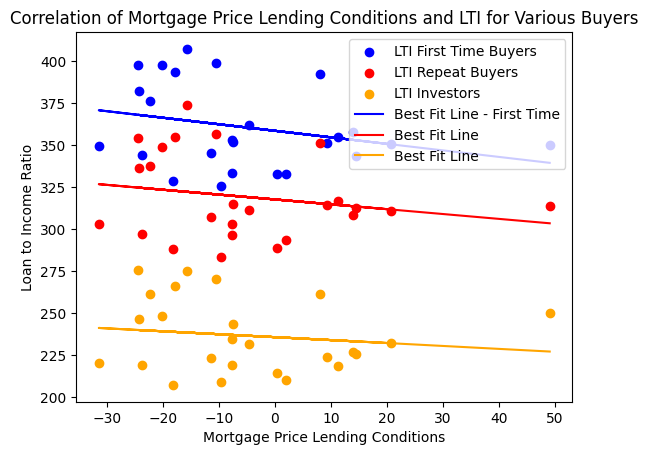

In [123]:

ax1 = plt.gca()

# scatter plot
ax1.scatter(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_FirstTime'], color='blue', label='LTI First Time Buyers')
ax1.scatter(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_RepeatBuyers'], color='red', label='LTI Repeat Buyers')
ax1.scatter(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_Investors'], color='orange', label='LTI Investors')
# calc bestfit line
slope_ft, intercept_ft = np.polyfit(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_FirstTime'], 1)
best_fit_line_ft = slope_ft * all_var_df['Mortgage_Price_Lending_Conditions'] + intercept_ft

slope_rpt, intercept_rpt = np.polyfit(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_RepeatBuyers'], 1)
best_fit_line_rpt = slope_rpt * all_var_df['Mortgage_Price_Lending_Conditions'] + intercept_rpt

slope_inv, intercept_inv = np.polyfit(all_var_df['Mortgage_Price_Lending_Conditions'], all_var_df['LTI_Investors'], 1)
best_fit_line_inv = slope_inv * all_var_df['Mortgage_Price_Lending_Conditions'] + intercept_inv

ax1.plot(all_var_df['Mortgage_Price_Lending_Conditions'], best_fit_line_ft, color='blue', label='Best Fit Line - First Time')
ax1.plot(all_var_df['Mortgage_Price_Lending_Conditions'], best_fit_line_rpt, color='red', label='Best Fit Line')
ax1.plot(all_var_df['Mortgage_Price_Lending_Conditions'], best_fit_line_inv, color='orange', label='Best Fit Line')
# labels
plt.xlabel('Mortgage Price Lending Conditions')
plt.ylabel('Loan to Income Ratio')
plt.title('Correlation of Mortgage Price Lending Conditions and LTI for Various Buyers')
plt.legend()

plt.show()

/var/folders/np/czhdb9qs1nv51rr1q76l8_br0000gn/T/ipykernel_99198/672386701.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_var_df['Quarter'] = pd.to_datetime(all_var_df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


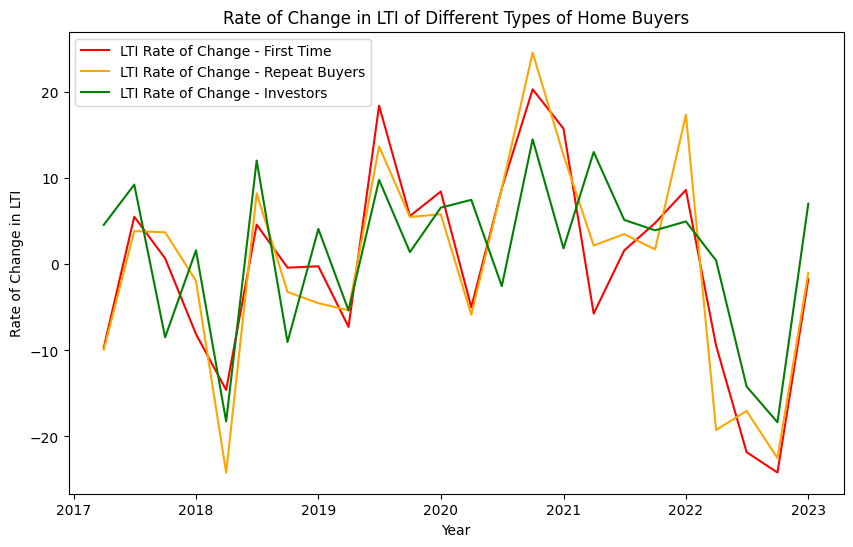

In [105]:
all_var_df['Quarter'] = pd.to_datetime(all_var_df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

# Plotting the data
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()  # Gets the current axis
ax1.plot(all_var_df['Quarter'], all_var_df['lti_ft_diff'], label='LTI Rate of Change - First Time', color='red')
ax1.plot(all_var_df['Quarter'], all_var_df['lti_rpt_diff'], label='LTI Rate of Change - Repeat Buyers', color='orange')
ax1.plot(all_var_df['Quarter'], all_var_df['lti_inv_diff'], label='LTI Rate of Change - Investors', color='green')

# title, labels, and legends
plt.title('Rate of Change in LTI of Different Types of Home Buyers')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rate of Change in LTI')

# legends
ax1.legend(loc='upper left')
plt.show()

/var/folders/np/czhdb9qs1nv51rr1q76l8_br0000gn/T/ipykernel_99198/621766663.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_var_df['Quarter'] = pd.to_datetime(all_var_df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')


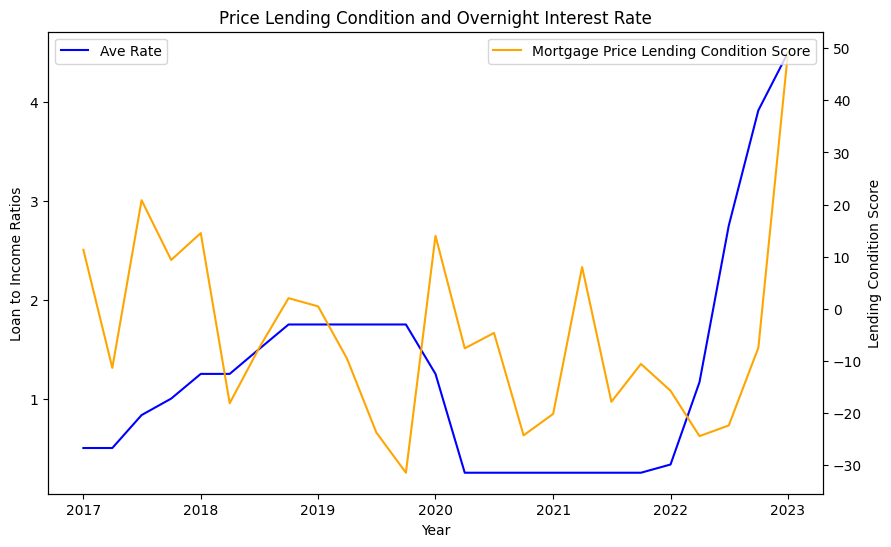

In [108]:
all_var_df['Quarter'] = pd.to_datetime(all_var_df['Quarter'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

plt.figure(figsize=(10, 6))

# first axis
ax1 = plt.gca()  # Gets the current axis
ax1.plot(all_var_df['Quarter'], all_var_df['Avg_Rate'], label='Ave Rate', color='blue')


# second axis
ax2 = ax1.twinx()  # Creates a second y-axis sharing the same x-axis
ax2.plot(all_var_df['Quarter'], all_var_df['Mortgage_Price_Lending_Conditions'], label='Mortgage Price Lending Condition Score', color='orange')

# Adding title, labels, and legends
plt.title('Price Lending Condition and Overnight Interest Rate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Loan to Income Ratios')
ax2.set_ylabel('Lending Condition Score')

# legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Text(0.5, 1.0, 'Correlation Matrix of All Variables')

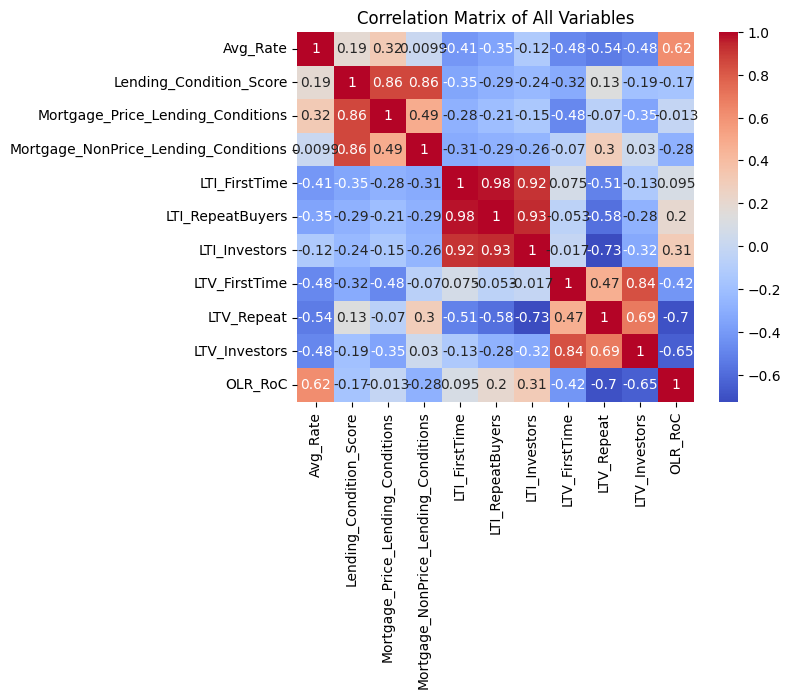

In [122]:
corr_matrix_all_var = all_var_df[['Avg_Rate','Lending_Condition_Score','Mortgage_Price_Lending_Conditions','Mortgage_NonPrice_Lending_Conditions','LTI_FirstTime','LTI_RepeatBuyers','LTI_Investors','LTV_FirstTime','LTV_Repeat','LTV_Investors','OLR_RoC']].corr()
sns.heatmap(corr_matrix_all_var, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of All Variables')


Lending conditions (both price and non price) appear to be essentially uncorrelated to the overnight lending rate.  This is a surprise as the overnight rate target is an essential component of a mortgage.  We see instances where the OLR dropped (Q2 2020) and both the price and non price lending conditions eased significantly.  In other non Covid related instances, the OLR increased and the lending conditions were also eased and tightened.  

This query constructs a table that simplifies the pairing with other datasets. It calculates the average geopolitical risk for each quarter and appropriately formats the date for consistency. Additionally, it computes the standard deviation, serving as a measure of volatility within each quarter. These two metrics – the average and the volatility – could prove instrumental in evaluating lending behavior, particularly since, at first glance, geopolitical risk seems tangentially related to mortgage activities.

Background on Pricing and Non-Pricing Conditions:

Pricing Conditions: 

Pricing conditions relate to how much the loan costs.  This inclues the interest rate, fees or any other fees required to get the loan.  Pricing conditions can be evaluated in a monetary value.


Non-Pricing Conditions: 

Non-Pricing conditions are perhaps a bit more esoteric as in they are a series of requirements like credit score, loan to value ratio or loan to income ratio etc.  Basically, these are the requirements or terms that you must meet in order to recieve and maintain your loan.  The non price conditions may infact provide more evidence as to the lending behaviour of the loan officers than the pricing conditions.  These conditions may also be more subject to biases and noise as they are a reflection of human judgement.  I will investigate this further. 

To start, I will assess.


To enhance my insight into the impact of lending behavior on consumers, I am integrating my data with Luke's (from the 'lukedb' database), utilizing his sentiment scores alongside my lending conditions data. To facilitate this, it's necessary first to compute the average sentiment scores by quarter. Additionally, I will calculate the standard deviation to gauge the variability within each quarter.

### References:

Bank of Canada. (n.d.). Indicators of financial vulnerabilities. Retrieved from https://www.bankofcanada.ca/rates/indicators/indicators-of-financial-vulnerabilities/#Loantoincome-ratio 

Bank of Canada. (n.d.). Posted interest rates offered by chartered banks. Retrieved from https://www.bankofcanada.ca/rates/banking-and-financial-statistics/posted-interest-rates-offered-by-chartered-banks/ 

Bank of Canada. (n.d.). Senior Loan Officer Survey. Retrieved from https://www.bankofcanada.ca/publications/slos/

Caldara, D., & Iacoviello, M. (2022). Measuring Geopolitical Risk. International Finance Discussion Papers, 1222r1. Board of Governors of the Federal Reserve System. https://doi.org/10.17016/IFDP.2022.1222r1

Iacoviello, M. (n.d.). Geopolitical Risk (GPR). Retrieved from https://www.matteoiacoviello.com/gpr.htm